## Optimal Taxation Simulation - Constant Elasticity

---

Following BSS's approach

Outline:

* Have individuals optimize （quasi-linear + iso-elastic)
* Numerically integrate FOC 
* Interpolate tax schedule
* Numerically optimize for $z$ and check z(w) is non-decreasing (throw an error otherwise)
* Repeat

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize

In [5]:
# some global constants
bin_start = 0.01
nbins = 1000
bin = 0.5
e = 1.5 
tol = 1e-6 # tolerance for termination

In [3]:
transfer = 0 # initially

### 1. Define the distribution and make a discretized version


We use a log normal distribution with $\mu = 2.757$ and $\sigma = 0.5611$ as MWY though we do not have an atom at $0.01$ for simplicity.

In [12]:
mu = 2.757
sigma = 0.5611

normal = norm(loc = mu, scale = sigma)

# exp^{normal} is log normal with the desired parameters 

wages = [0.01 + bin * i for i in range(0, nbins)] # synnonymous with ability, for now

### 2. Define agents

The utility function we use is:

$$U(c, l) = u(c) + v(l) = c - \frac{n}{1 + 1/e} \cdot \bigg(\frac{z}{n}\bigg)^{1 + 1/e}$$

s.t.

$$ c \leq w \cdot l - T(w \cdot l)$$

Note that $T(0) = -R$ is the transfer.

In [47]:
class Agent:

    def __init__(self, wage):

        # note that this is a separating equilibrium, so higher ability workers always work more 
        # okay to assume the relative ordering stays the same over time

        self.wage = wage
        self.ls = (alpha/((0.65 * self.wage)**(1 - gamma)))**(1/(1 - gamma - sigma)) # the guessed labor supply assuming a flat rate of 0.35
        self.dudc = None # u'(c(theta))
        self.consumption = None
        self.taxpaid = None

    def taxes(self, tax_schedule, earnings):
        '''
        This function calculates the tax burden for this agent.
        When it comes to the i^{th} agent, the previous agents' earnings would have been calculated (see the description up top).

        Inputs:
        tax_schedule: a list of tuples (cutoff, rate), where the i^{th} entry is (w(z_i), T'(w))

        Returns:
        (float) tax burden
        '''

        total_tax = 0 # cumulative tax burden
        prev_cutoff = tax_schedule[0][0]

        for i in range(self.bracket - 1):

            cutoff, rate = tax_schedule[i]
            
            if earnings < cutoff:
                break

            total_tax += rate * (cutoff - prev_cutoff)
            prev_cutoff = cutoff

        total_tax += (earnings - max(prev_cutoff, 0)) * tax_schedule[self.bracket - 1][1]

        return total_tax
    
    def max_util(self, transfer, tax_schedule):
        '''
        utility maximization assuming walrus's law holds (no extra budget)
        transfer: from the government.
        tax schedule: see definition aboe
        '''
        
        # negative of the utility function since the routine minimizes instead of optimizes
        
        neg_utility_func = lambda l: -1 * ((self.wage*l - self.taxes(tax_schedule, self.wage*l) + transfer)**(1 - gamma) - 1)/(1 - gamma) + alpha*(l**(sigma)) / sigma if l >= 0 else 1e9
        result = minimize(neg_utility_func, self.ls)

        self.ls = result.x[0] # new optimal labor supply
        self.taxpaid = self.taxes(tax_schedule, self.wage*self.ls)
        self.consumption = self.wage*self.ls - self.taxpaid + transfer
        self.dudc = (self.wage*self.ls - self.taxes(tax_schedule, self.wage*self.ls) + transfer)**(-1 * gamma) # should do numerical differentiation for general utility functions

        return self.ls*self.wage # pre-tax earnings this turn

Intialization for the search is important for the speed of convergence. We use the previous optimal labor supply as an educated guess for the starting point of the search under the new schedule.

### 3. Iterating to find the fixed point

#### 3.1 - Intialize a starting tax schedule $(T'(w) \equiv 0.35)$

In [48]:
# initially - initialize the economy - flat tax schedule
agents = []
tax_schedule = [(0, 0.35)]
for wage in wages:
    agent = Agent(wage)
    optimal_wage = agent.max_util(transfer, tax_schedule)
    tax_schedule.append((optimal_wage, 0.35))
    agents.append(agent)
tax_schedule.pop(0)

(0, 0.35)

#### Update rule:

Planner's FOC (a discretized version of Saez's FOC from his seminal 2001 paper), discretized (see pg. 5 of MWY's appendix):

$$\frac{T'(z)}{(1 - T'(z))} = \frac{1 + \epsilon^u(w)}{\epsilon^c(w)}\frac{u'(c(w))}{w\pi(w)/\Delta}\bigg[\sum_{w_i = w + 1}^{w_N} \frac{\pi(w_i)}{u'(c(w_i))} - (1 - \Pi(w_i)) \sum_{w_i = w_1}^{w_N} \frac{\pi(w_i)}{u'(c(w_i))}\bigg]$$

In [49]:
iterations = 0

while True:

    print(iterations, end = " ")

    revenue_check = True # if the new tansfer is within 1e-6 of the prev
    derivative_check = True # if marginal taxes are not updated by more than 1e-6

    # components of RHS
    cum_sum = [pmf[0]/agents[0].dudc]
    for (idx, agent) in enumerate(agents[1:]):
        cum_sum.append(cum_sum[-1] + pmf[idx]/agent.dudc)

    for (index, agent) in enumerate(agents):

        # calculate the new tax rate:
        e_c = 1/(sigma - 1 + alpha * gamma * (agent.ls**sigma) * (agent.consumption ** (gamma - 1))) # compensated elasticity
        e_u = (1 - alpha * gamma * (agent.ls**sigma) * (agent.consumption ** (gamma - 1)))/(sigma - 1 + alpha * gamma * (agent.ls**sigma) * (agent.consumption ** (gamma - 1))) # uncompensated elasticity
        middle_term = agent.dudc/(wages[index] * pmf[index] / bin)
        right_term = (cum_sum[-1] - cum_sum[index]) - (1 - cdf[index]) * cum_sum[-1]
        rhs = (1 + e_u)/e_c * middle_term * right_term
        new_rate = rhs / (1 + rhs)

        # find the new schedule
        if abs(new_rate - tax_schedule[index][1]) > tol:
            derivative_check = False
        
        tax_schedule[index] = (tax_schedule[index][0], new_rate)

    # find the government revenue under this new schedule
    revenue = 0
    for (index, agent) in enumerate(agents):
        pre_tax_earning = agent.max_util(transfer, tax_schedule)
        revenue += agent.taxpaid * pmf[index]
        tax_schedule[index] = (pre_tax_earning, tax_schedule[index][1])

    if abs(transfer - revenue) > tol:
        revenue_check = False

    transfer = revenue
     
    if revenue_check and derivative_check:
        break

    for (index, agent) in enumerate(agents):
        pre_tax_earning = agent.max_util(transfer, tax_schedule) # now again with the new transfer
        tax_schedule[index] = (pre_tax_earning, tax_schedule[index][1])

    iterations += 1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 

### Visuals:

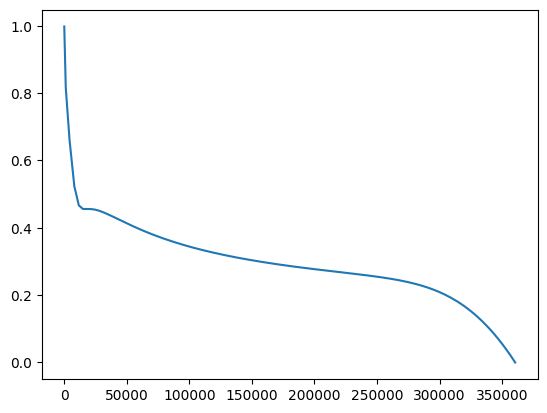

In [50]:
changes = []
rate = []

for point in tax_schedule:
    changes.append(point[0] * scaling)
    rate.append(point[1])

plt.plot(changes, rate)